In [15]:
!pip install virtualenv


In [16]:
!virtualenv /content/3dmodel


created virtual environment CPython3.11.12.final.0-64 in 535ms
  creator CPython3Posix(dest=/content/3dmodel, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==25.1.1, setuptools==80.3.1
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [17]:
import sys
sys.path.append('/content/myenv/lib/python3.7/site-packages')

# Text to 3D model creation

Introduction:
-------------
This project aims to explore the potential of AI-generated 3D models from text prompts. Using OpenAI’s Shap-E model, we generate 3D object meshes that are directly based on natural language descriptions. The project enables users to input text like "a cute dog" or "a futuristic car" and instantly receive corresponding 3D models in the .obj format.

By combining state-of-the-art diffusion models with 3D rendering techniques, this project makes 3D model generation accessible and easy for anyone, even those without prior experience in 3D modeling or programming.

Downloads the full Shap-E source code (including models, utilities, examples) into your Colab runtime or local directory.

Creates a folder called shap-e containing the codebase.

You can then import and use Shap-E models directly in your notebook or Python script.

In [18]:
!git clone https://github.com/openai/shap-e


Cloning into 'shap-e'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 336 (delta 35), reused 13 (delta 13), pack-reused 281 (from 2)
Receiving objects: 100% (336/336), 11.72 MiB | 16.14 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [19]:
%cd shap-e

/content/shap-e/shap-e


In [20]:
!pip install -e .

Obtaining file:///content/shap-e/shap-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-s01ihnbb/clip_f84e5a96e680423f9acf48399e59d232
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-s01ihnbb/clip_f84e5a96e680423f9acf48399e59d232
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Attempting uninstall: shap-e
    Found existing installation: shap-e 0.0.0
    Uninstalling shap-e-0.0.0:
      Successfully uninstalled shap-e-0.0.0
  Running setup.py develop for shap-e


In [21]:
!pip install trimesh


In [22]:
from google.colab import files


In [23]:
!pip freeze > requirements.txt
files.download('requirements.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import trimesh
from shap_e.diffusion.sample import sample_latents
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
from shap_e.models.download import load_model, load_config
from shap_e.util.notebooks import create_pan_cameras, decode_latent_images, gif_widget, decode_latent_mesh


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
try:
    xm = load_model("transmitter", device=device)
    model = load_model("text300M", device=device)
except Exception as e:
    print("Model loading failed:", e)

diffusion = diffusion_from_config(load_config("diffusion"))

# Function to create latent
def create_latent(batch_size, prompt, guidance_scale):
    latents = sample_latents(
        batch_size=batch_size,
        model=model,
        diffusion=diffusion,
        guidance_scale=guidance_scale,
        model_kwargs=dict(texts=[prompt] * batch_size),
        progress=True,
        clip_denoised=True,
        use_fp16=True,
        use_karras=True,
        karras_steps=64,
        sigma_min=1e-3,
        sigma_max=160,
        s_churn=0,
    )
    return latents

# Write mesh data to an OBJ file
def save_mesh_as_obj(mesh, filename):
    with open(filename, 'w') as f:
        for v in mesh.verts:
            f.write(f'v {v[0]} {v[1]} {v[2]}\n')
        for face in mesh.faces:
            f.write(f'f {face[0] + 1} {face[1] + 1} {face[2] + 1}\n')

# Decode and save a 3D mesh from latent data
def save_file(latent, filename="cat.obj"):
    if latent is None:
        print("❌ Error: No latent data available to save.")
        return

    mesh_decoder = load_model("decoder", device=device)
    latent = latent.to(device)
    mesh = decode_latent_mesh(mesh_decoder,latent)
    save_mesh_as_obj(mesh, filename)
    print(f"✅ Saved as {filename}")
    files.download(filename)

# Display model
def display_model(latent, render_mode="nerf", size=128):
    cameras = create_pan_cameras(size, device)
    latent=latent.to(device)
    images = decode_latent_images(xm, latent, cameras, rendering_mode=render_mode)
    return display(gif_widget(images))
# Simple 3D Matplotlib visualization of the saved .obj
def visualize_obj_matplotlib(obj_path):
    mesh = trimesh.load(obj_path)
    verts = mesh.vertices
    faces = mesh.faces

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    mesh_collection = Poly3DCollection(verts[faces], alpha=0.7)
    mesh_collection.set_facecolor([0.5, 0.5, 1])
    mesh_collection.set_edgecolor('k')
    ax.add_collection3d(mesh_collection)

    ax.set_xlim(verts[:, 0].min(), verts[:, 0].max())
    ax.set_ylim(verts[:, 1].min(), verts[:, 1].max())
    ax.set_zlim(verts[:, 2].min(), verts[:, 2].max())
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title("Simple 3D View of Generated Mesh")
    plt.tight_layout()
    plt.show()


  0%|          | 0/64 [00:00<?, ?it/s]

✅ Saved as parrot.obj


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

HTML(value='<img src="data:image/gif;base64,R0lGODlhgACAAIcAAKmqqampqKipqaipqKioqKeoqKiop6eop6eopKenqKenp6enpq…

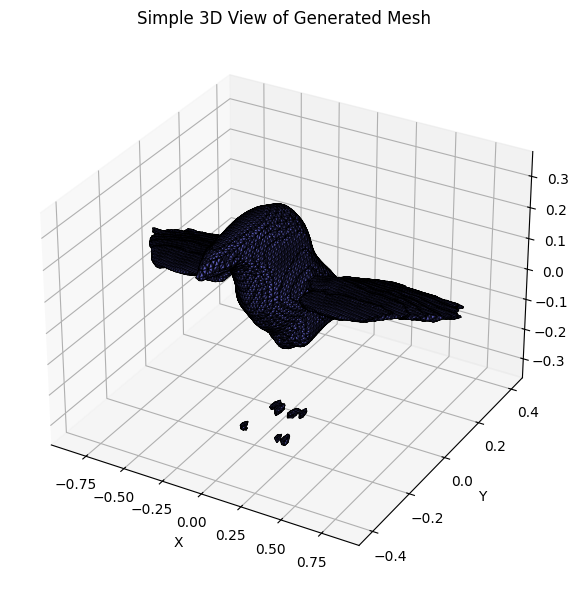

In [32]:

# MAIN
if __name__ == "__main__":
    batch_size = 1
    guidance_scale = 15.0
    prompt = "bird"
    filename = "parrot.obj"
    latents = create_latent(batch_size, prompt, guidance_scale)
    latent = latents[0].cpu()

    save_file(latent, filename)
    display_model(latent, "nerf", 128) # we can use stf as well as a render_mode
    visualize_obj_matplotlib(filename)
